In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.insert(1, r'C:\Users\jacki\OneDrive\Jobs\2021\Fulltime\UBS QIS')

from datetime import datetime, timedelta
from math import log, exp
import pandas as pd
from bookirds.curves import *
from bookirds.bsplines import BSpline
from bookirds.dual import Dual
import matplotlib.pyplot as plt
from backtesting.input.bbg import get_price,get_field
from backtesting.implementation.utils import merge_dfs
import matplotlib.ticker as ticker


In [2]:
nodes_short = {
    datetime(2023, 8, 25): 1.00,  # today's DF
    datetime(2023, 9, 20): 1.00,  # defined MPC dates..
    datetime(2023, 11, 1): 1.00,
    datetime(2023, 12, 13): 1.00,
    datetime(2024, 1, 31): 1.00, # provisional MPC dates..
    datetime(2024, 3, 20): 1.00,
    datetime(2024, 5, 1): 1.00,
    datetime(2024, 6, 12): 1.00,
    datetime(2024, 7, 31): 1.00,
    datetime(2024, 9, 18): 1.00,  
    datetime(2024, 11, 7): 1.00,
    datetime(2024, 12, 18): 1.00,
    datetime(2025, 1, 29): 1.00, # estimated MPC dates..
    datetime(2025, 3, 20): 1.00,  
    datetime(2025, 5, 1): 1.00,
    datetime(2025, 6, 12): 1.00,
    datetime(2025, 7, 31): 1.00,
    datetime(2025, 9, 18): 1.00,
    datetime(2025, 11, 7): 1.00,
    datetime(2025, 12, 18): 1.00,
    datetime(2026, 3, 18): 1.00, # strategic IMM dates
    datetime(2026, 6, 17): 1.00,
}

nodes = {**nodes_short,**{    
    #datetime(2027, 9, 15): 1.00,# long term tenors..
    datetime(2028, 9, 20): 1.00, 
    datetime(2030, 9, 18): 1.00,
    datetime(2033, 9, 21): 1.00,
    datetime(2038, 9, 15): 1.00,
    datetime(2043, 9, 16): 1.00,
    datetime(2053, 9, 17): 1.00,
    datetime(2063, 9, 19): 1.00,
    datetime(2073, 9, 20): 1.00,}}

nodes_dual = {k: Dual(v, {f"v{i}": 1}) for i, (k,v) in enumerate(nodes.items())}

In [3]:
ini_swaps = {
    Swap(datetime(2023, 8, 25), 26, 26, 26, days=True): 5.315320,
    Swap(datetime(2023, 9, 20), 3, 3, 3): 5.4543,
    Swap(datetime(2023, 12, 20), 3, 3, 3): 5.4868,
    Swap(datetime(2024, 3, 20), 3, 3, 3): 5.3482,
    Swap(datetime(2024, 6, 19), 3, 3, 3): 5.0634,
    Swap(datetime(2024, 9, 18), 3, 3, 3): 4.6874,
    Swap(datetime(2024, 12, 18), 3, 3, 3): 4.3304,
    Swap(datetime(2025, 3, 19), 3, 3, 3): 4.0572,
    Swap(datetime(2025, 6, 18), 3, 3, 3): 3.8830,
    Swap(datetime(2025, 9, 17), 3, 3, 3): 3.7877,
    Swap(datetime(2025, 12, 17), 3, 3, 3): 3.7414,
    Swap(datetime(2026, 3, 18), 3, 3, 3): 3.7092,
    Swap(datetime(2026, 6, 17), 3, 3, 3): 3.6759,
    #Swap(datetime(2023, 8, 25), 12*4, 12, 12): 4.360598,
    Swap(datetime(2023, 8, 27), 12*5, 12, 12): 4.215,
    Swap(datetime(2023, 8, 27), 12*7, 12, 12): 4.063449,
    Swap(datetime(2023, 8, 27), 12*10, 12, 12): 3.967500,
    Swap(datetime(2023, 8, 27), 12*15, 12, 12): 3.931250,
    Swap(datetime(2023, 8, 27), 12*20, 12, 12): 3.865250,
    Swap(datetime(2023, 8, 27), 12*30, 12, 12): 3.627000,
    Swap(datetime(2023, 8, 27), 12*40, 12, 12): 3.408450,
    Swap(datetime(2023, 8, 27), 12*50, 12, 12): 3.197351,
}

In [4]:
ini_s_cv = SolvedCurve(
    nodes=nodes_dual, interpolation="log_linear", 
    swaps=list(ini_swaps.keys()), obj_rates=list(ini_swaps.values()),
    algorithm="levenberg_marquardt", 
)
print(ini_s_cv.iterate())

tolerance reached (levenberg_marquardt) after 16 iterations, func: 2.767584423945284e-14


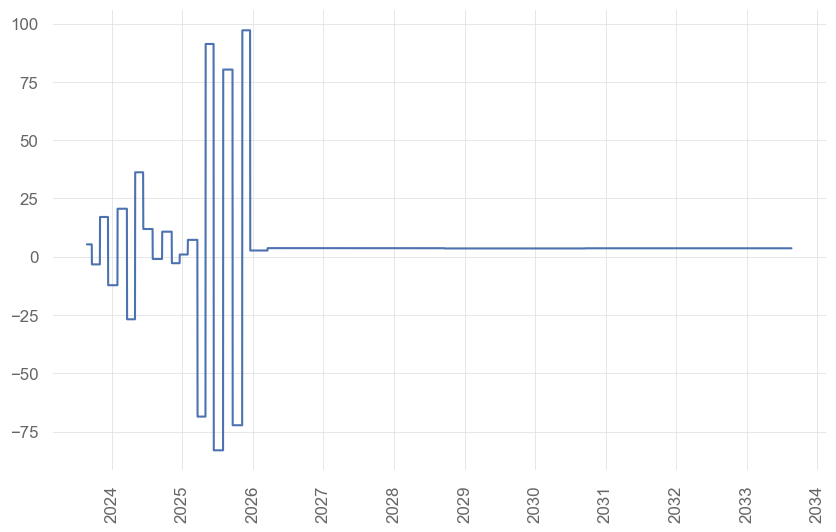

In [5]:
fig, ax = plt.subplots()
x = [datetime(2023,8,25) + i * timedelta(days=1) for i in range(365*10)]
z = [ini_s_cv.rate(date, days=1).real for date in x]
ax.plot(x, z)
# ax.set_xlim(datetime(2023,1,1),datetime(2024,9,30))
# ax.set_ylim(2.3,2.75)
plt.xticks(rotation=90)
plt.show()

In [6]:
mpc_1 = Swap(datetime(2023, 9, 20), 1, 1, 1, days=True)
mpc_2 = Swap(datetime(2023, 11, 1), 1, 1, 1, days=True)
mpc_3 = Swap(datetime(2023, 12, 13), 1, 1, 1, days=True)
mpc_4 = Swap(datetime(2024, 1, 31), 1, 1, 1, days=True)
mpc_5 = Swap(datetime(2024, 3, 20), 1, 1, 1, days=True)
mpc_6 = Swap(datetime(2024, 5, 1), 1, 1, 1, days=True)
mpc_7 = Swap(datetime(2024, 6, 12), 1, 1, 1, days=True)
mpc_8 = Swap(datetime(2024, 7, 31), 1, 1, 1, days=True)
mpc_9 = Swap(datetime(2024, 9, 18), 1, 1, 1, days=True)
mpc_10 = Swap(datetime(2024, 11, 7), 1, 1, 1, days=True)
mpc_11 = Swap(datetime(2024, 12, 18), 1, 1, 1, days=True)
mpc_12 = Swap(datetime(2025, 1, 29), 1, 1, 1, days=True)
mpc_13 = Swap(datetime(2025, 3, 20), 1, 1, 1, days=True)
mpc_14 = Swap(datetime(2025, 5, 1), 1, 1, 1, days=True)
mpc_15 = Swap(datetime(2025, 6, 12), 1, 1, 1, days=True)
mpc_16 = Swap(datetime(2025, 7, 31), 1, 1, 1, days=True)
mpc_17 = Swap(datetime(2025, 9, 18), 1, 1, 1, days=True)
mpc_18 = Swap(datetime(2025, 11, 7), 1, 1, 1, days=True)
mpc_19 = Swap(datetime(2025, 12, 18), 1, 1, 1, days=True)
mpc_20 = Swap(datetime(2026, 3, 18), 1, 1, 1, days=True)
#mpc_21 = Swap(datetime(2026, 6, 17), 1, 1, 1, days=True)

curvature_conds = {
SwapSpread(SwapSpread(mpc_1, mpc_2), SwapSpread(mpc_2, mpc_3)): 0,
SwapSpread(SwapSpread(mpc_2, mpc_3), SwapSpread(mpc_3, mpc_4)): 0,
SwapSpread(SwapSpread(mpc_3, mpc_4), SwapSpread(mpc_4, mpc_5)): 0,
SwapSpread(SwapSpread(mpc_4, mpc_5), SwapSpread(mpc_5, mpc_6)): 0,
SwapSpread(SwapSpread(mpc_5, mpc_6), SwapSpread(mpc_6, mpc_7)): 0,
SwapSpread(SwapSpread(mpc_6, mpc_7), SwapSpread(mpc_7, mpc_8)): 0,
SwapSpread(SwapSpread(mpc_7, mpc_8), SwapSpread(mpc_8, mpc_9)): 0,
SwapSpread(SwapSpread(mpc_8, mpc_9), SwapSpread(mpc_9, mpc_10)): 0,
SwapSpread(SwapSpread(mpc_9, mpc_10), SwapSpread(mpc_10, mpc_11)): 0,
SwapSpread(SwapSpread(mpc_10, mpc_11), SwapSpread(mpc_11, mpc_12)): 0,
SwapSpread(SwapSpread(mpc_11, mpc_12), SwapSpread(mpc_12, mpc_13)): 0,
SwapSpread(SwapSpread(mpc_12, mpc_13), SwapSpread(mpc_13, mpc_14)): 0,
SwapSpread(SwapSpread(mpc_13, mpc_14), SwapSpread(mpc_14, mpc_15)): 0,
SwapSpread(SwapSpread(mpc_14, mpc_15), SwapSpread(mpc_15, mpc_16)): 0,
SwapSpread(SwapSpread(mpc_15, mpc_16), SwapSpread(mpc_16, mpc_17)): 0,
SwapSpread(SwapSpread(mpc_16, mpc_17), SwapSpread(mpc_17, mpc_18)): 0,
SwapSpread(SwapSpread(mpc_17, mpc_18), SwapSpread(mpc_18, mpc_19)): 0,
SwapSpread(SwapSpread(mpc_18, mpc_19), SwapSpread(mpc_19, mpc_20)): 0,
}
 
swaps = {**ini_swaps, **curvature_conds}
s_cv = SolvedCurve(
    nodes=nodes_dual, interpolation="log_linear",
    swaps=list(swaps.keys()), obj_rates=list(swaps.values()),
    algorithm="levenberg_marquardt", w = [1]*len(ini_swaps) + [0.0001]*len(curvature_conds)
)
print(s_cv.iterate())

tolerance reached (levenberg_marquardt) after 12 iterations, func: 0.001081246960560429


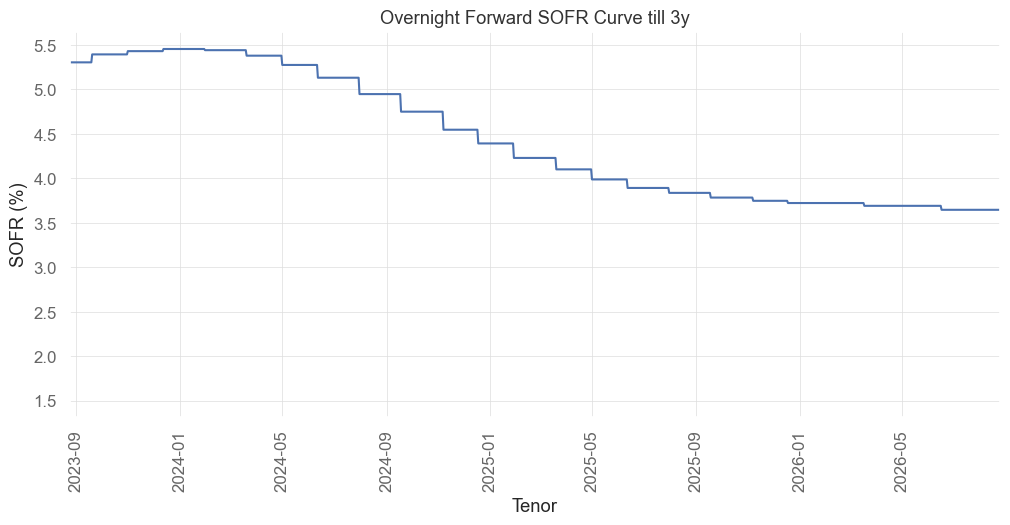

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
x = [datetime(2023,8,25) + i * timedelta(days=1) for i in range(365*50)]
z = [s_cv.rate(date, days=1).real for date in x]
ax.set_xlim(datetime(2023,8,25),datetime(2026,8,25))
ax.plot(x, z)
ax.set_ylabel('SOFR (%)')
ax.set_xlabel('Tenor')
plt.title('Overnight Forward SOFR Curve till 3y')
plt.xticks(rotation=90)
plt.show()

In [8]:
swaps = {**ini_swaps, **curvature_conds}
weights = [1]*len(ini_swaps)+ [0.01]*len(curvature_conds)

In [9]:
t_layer_1 = [
    datetime(2026, 3, 18), datetime(2026, 3, 18), datetime(2026, 3, 18), datetime(2026, 3, 18),
    datetime(2026, 6, 17),
    #datetime(2027, 9, 15),
    datetime(2028, 9, 20),
    datetime(2030, 9, 18),
    datetime(2033, 9, 21),
    datetime(2038, 9, 15),
    datetime(2043, 9, 16),
    datetime(2053, 9, 17),
    datetime(2063, 9, 19),
    datetime(2073, 9, 20), datetime(2073, 9, 20), datetime(2073, 9, 20), datetime(2073, 9, 20),
    ]

adv_cv_1 = AdvancedCurve(
    nodes=nodes_dual, interpolation="log_linear", 
    swaps=list(swaps.keys()), obj_rates=list(swaps.values()), t=t_layer_1,
    algorithm="levenberg_marquardt", 
    w=weights,
)
print(adv_cv_1.iterate())


basic solve:  tolerance reached (levenberg_marquardt) after 12 iterations, func: 0.0012064260334525726
tolerance reached (gauss_newton) after 4 iterations, func: 0.00012643335602552605


In [10]:
x = [datetime(2023,8,25) + i * timedelta(days=1) for i in range(365*50)]
z = [adv_cv_1.rate(date, days=1).real for date in x]

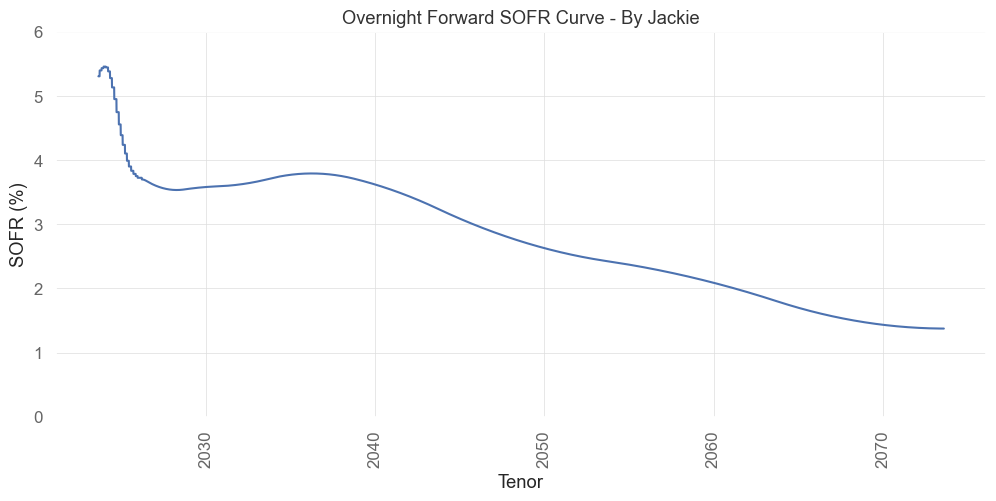

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
#ax.set_xlim(datetime(2023,8,25),datetime(2027,9,30))
ax.set_ylim(0,6)
ax.plot(x, z)
ax.set_ylabel('SOFR (%)')
ax.set_xlabel('Tenor')
plt.title('Overnight Forward SOFR Curve - By Jackie')
plt.xticks(rotation=90)
plt.show()

In [12]:
recovered_rates = [swap.rate(adv_cv_1).real for swap in ini_swaps.keys()] 
end = [swap.end for swap in ini_swaps.keys()] 
df_compare = pd.DataFrame(index=end,data={'implied':np.array(recovered_rates)*100,
                                          'market':np.array(list(ini_swaps.values()))*100})
df_compare['difference'] = df_compare['implied'] - df_compare['market']

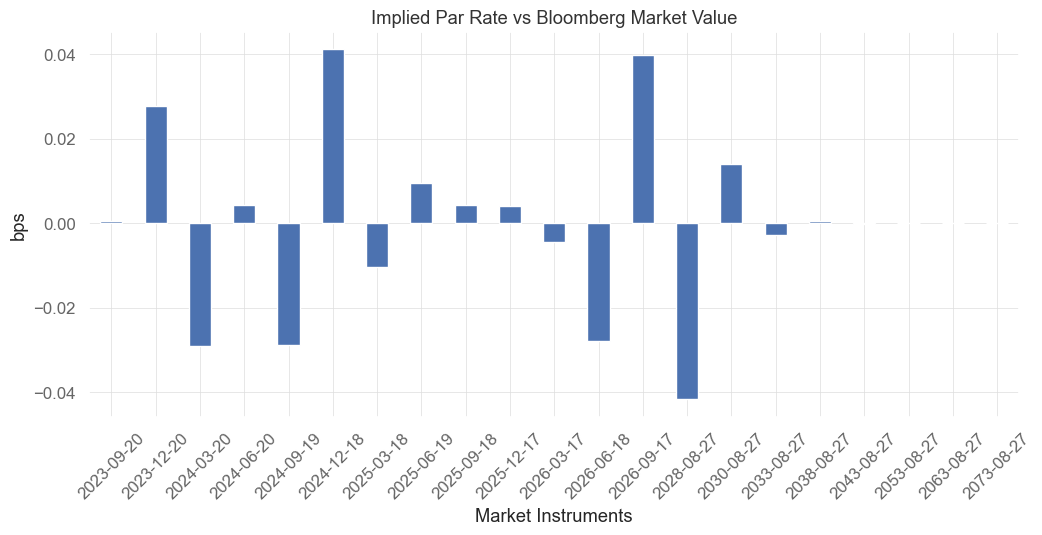

In [13]:
fig, ax =plt.subplots(figsize=(12,5)) 
df_compare.difference.plot(kind='bar', title = 'Implied Par Rate vs Bloomberg Market Value',ax=ax)
ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in df_compare.index], rotation=45)
ax.set_ylabel('bps')
ax.set_xlabel('Market Instruments')
plt.show()

In [14]:

skews_layer_2 = {
    Swap(datetime(2023, 8, 27), 12*4, 12, 12): 0,
    #Swap(datetime(2023, 8, 25), 12*6, 12, 12): 0,
    Swap(datetime(2023, 8, 27), 12*8, 12, 12): -0.0005,
    Swap(datetime(2023, 8, 27), 12*9, 12, 12): -0.0005,
    Swap(datetime(2023, 8, 27), 12*12, 12, 12): -0.0002,
    Swap(datetime(2023, 8, 27), 12*25, 12, 12): -0.005,
    Swap(datetime(2023, 8, 27), 12*35, 12, 12): +0.004,
    Swap(datetime(2023, 8, 27), 12*45, 12, 12): +0.007,
}

t_layer_2 = [
    datetime(2026, 3, 18), datetime(2026, 3, 18), datetime(2026, 3, 18), datetime(2026, 3, 18),
    datetime(2026, 6, 17),
         datetime(2027, 9, 15),  # 4y
         #datetime(2029, 9, 19),  # 6y
    datetime(2028, 9, 20),
    datetime(2030, 9, 18),
         datetime(2031, 9, 17),  # 8y
         datetime(2032, 9, 21),  # 9y
    datetime(2033, 9, 21),
         datetime(2035, 9, 19),  # 12y
    datetime(2038, 9, 15),
    datetime(2043, 9, 16),
         datetime(2048, 9, 16),  # 25y
    datetime(2053, 9, 17),
         datetime(2058, 9, 18),  # 35y
    datetime(2063, 9, 19),
         datetime(2068, 9, 19),  # 45y
    datetime(2073, 9, 20), datetime(2073, 9, 20), datetime(2073, 9, 20), datetime(2073, 9, 20),
    ]

swaps_layer_2 = {
    swap: swap.rate(adv_cv_1).real + skew for (swap, skew) in skews_layer_2.items()
}

nodes_2 = {**nodes_short, **{
    datetime(2027, 9, 15): 1.00,# long term tenors..
    datetime(2028, 9, 20): 1.00, 
    #datetime(2029, 9, 19): 1.00,
    datetime(2030, 9, 18): 1.00,
    datetime(2031, 9, 17): 1.00, 
    datetime(2032, 9, 21): 1.00, 
    datetime(2033, 9, 21): 1.00,
    datetime(2035, 9, 19): 1.00,
    datetime(2038, 9, 15): 1.00,
    datetime(2043, 9, 16): 1.00,
    datetime(2048, 9, 16): 1.00,
    datetime(2053, 9, 17): 1.00,
    datetime(2058, 9, 18): 1.00,
    datetime(2063, 9, 19): 1.00,
    datetime(2068, 9, 19): 1.00,
    datetime(2073, 9, 20): 1.00,
}}
nodes_dual_2 = {k: Dual(v, {f"v{i}": 1}) for i, (k,v) in enumerate(nodes_2.items())}


swaps_2 = {**ini_swaps, **swaps_layer_2, **curvature_conds}
weights_2 = [1]*(len(ini_swaps)+len(swaps_layer_2)) + [0.0001]*len(curvature_conds)


adv_cv_2 = AdvancedCurve(
    nodes=nodes_dual_2, interpolation="log_linear", 
    swaps=list(swaps_2.keys()), obj_rates=list(swaps_2.values()), t=t_layer_2,
    algorithm="levenberg_marquardt", 
    w=weights_2
)
print(adv_cv_2.iterate())

basic solve:  tolerance reached (levenberg_marquardt) after 12 iterations, func: 0.00023125704154067952
tolerance reached (gauss_newton) after 3 iterations, func: 1.271600780990617e-06


In [15]:
x = [datetime(2023,8,25) + i * timedelta(days=1) for i in range(365*50)]
y = [adv_cv_1.rate(date, days=1).real for date in x]
z = [adv_cv_2.rate(date, days=1).real for date in x]
w = [s_cv.rate(date, days=1).real for date in x]

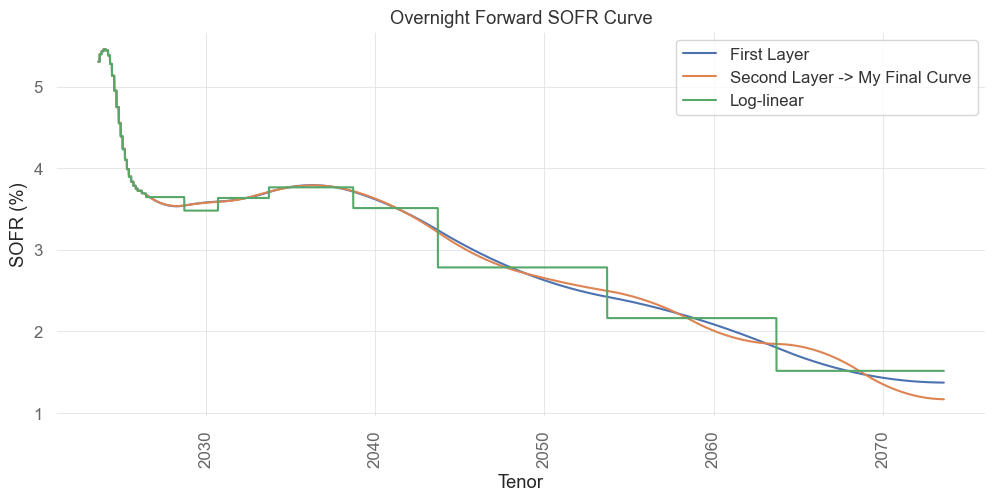

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x, y,label = 'First Layer')
ax.plot(x, z,label = 'Second Layer -> My Final Curve')
ax.plot(x, w,label = 'Log-linear')
ax.set_ylabel('SOFR (%)')
ax.set_xlabel('Tenor')
plt.title('Overnight Forward SOFR Curve')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [17]:
to_compare_tenor = [4,5,6,7,8,9,10,12,15,20,25,30,35,40,45,50]
to_compare_ticker = ['USOSFR{} BGN Curncy'.format(i) for i in to_compare_tenor]
df_bbg = pd.DataFrame(index = to_compare_ticker,columns=['Tenor','Yield'])
for j,i in enumerate(to_compare_ticker):
    df_bbg.loc[df_bbg.index==i,'Yield'] = get_field(i,'PX_LAST',start='20230825',end='20230825').values[0][0]
    df_bbg.loc[df_bbg.index==i,'Tenor'] = '{}Y'.format(to_compare_tenor[j])

In [18]:
test_swaps = [Swap(datetime(2023, 8, 27), 12*i, 12, 12) for i in to_compare_tenor]

recovered_rates_adv_cv_1 = [swap.rate(adv_cv_1).real for swap in test_swaps] 
recovered_rates_adv_cv_2 = [swap.rate(adv_cv_2).real for swap in test_swaps] 
recovered_rates_s_cv = [swap.rate(s_cv).real for swap in test_swaps] 


In [19]:
df_bbg['Yield by log-linear'] = recovered_rates_s_cv
df_bbg['Yield by first layer'] = recovered_rates_adv_cv_1
df_bbg['Yield by second layer'] = recovered_rates_adv_cv_2

In [20]:
df_bbg.to_clipboard()

In [21]:
x_index = [datetime(2023,8,27) + i * timedelta(days=1) for i in range(365*50)]
par_swaps = [Swap(datetime(2023, 8, 27), i+1, 365, 365,days=True) for i in range(365*50)]
par_swaps_yield_adv_cv_2 = [swap.rate(adv_cv_2).real for swap in par_swaps] 

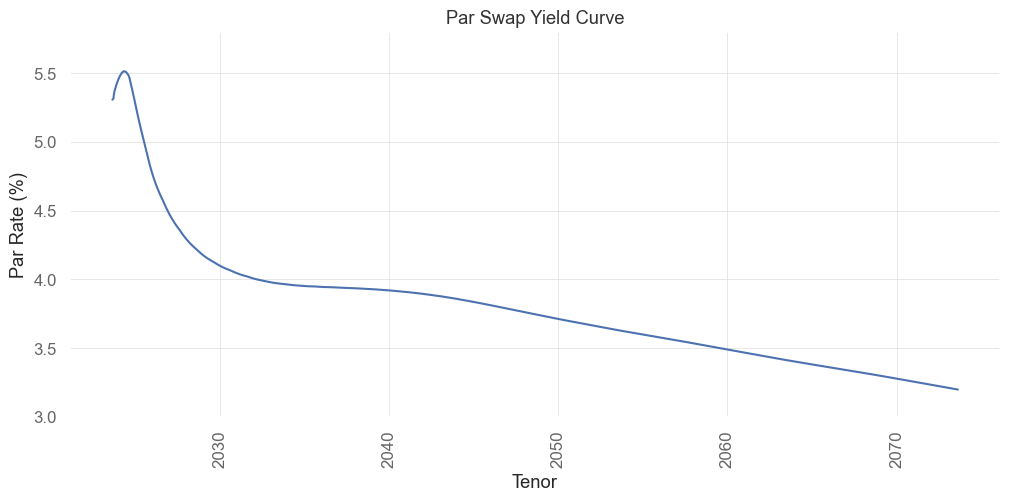

In [22]:

fig, ax = plt.subplots(figsize=(12,5))
ax.set_ylim(0,6)
ax.plot(x_index, par_swaps_yield_adv_cv_2)
ax.set_ylabel('Par Rate (%)')
ax.set_xlabel('Tenor')
ax.set_ylim(3,5.8)
plt.title('Par Swap Yield Curve')
plt.xticks(rotation=90)
plt.show()